# Goal:
1. This tutorial shows how to caliberate a image from perspectives to the ground with simple opencv methods.
2. Then we show how we transform the detected people to the ground.

```
conda create -n spatial python=3.10
conda activate spatial
conda config --env --add channels conda-forge
conda config --env --set channel_priority strict
conda install python=3 geopandas gdal
```

In [6]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import os
import pandas as pd
from osgeo import gdal
from osgeo import osr

In [2]:
# general function
def imshow(image, show_axes = False, quiet = False):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image)
    if not show_axes:
        # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
        plt.axis('off')
    if not quiet:
        # Make sure it outputs
        plt.show()

In [3]:
folder = "../data"
images = os.listdir(folder)
images

['A_perspective.jpg',
 'A_plan.tif',
 'cityroller-frame.jpg',
 'cityroller-trim.mp4',
 'cityroller.mp4',
 'hvectorsA2.csv',
 'trace_a_1000_1500.csv']

In [30]:
targetimg  = cv2.cvtColor(cv2.imread(os.path.join(folder, 'A_plan.tif')),cv2.COLOR_BGR2RGB)
originimg  = cv2.cvtColor(cv2.imread(os.path.join(folder, 'frame_1222.jpg')),cv2.COLOR_BGR2RGB) # this is a frame from the video

In [7]:

dsA = gdal.Open(os.path.join(folder, 'A_plan.tif'))

## Find H matrix

In [8]:
hmatrix = pd.read_csv(os.path.join(folder, 'hvectorsA2.csv'))
# Compute the corners of the region of interest


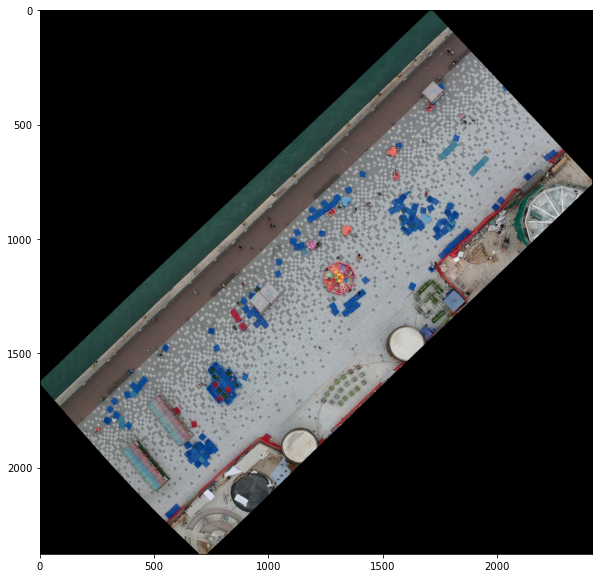

In [9]:

fig = plt.subplots(figsize = (10,10))
plt.imshow(targetimg)

plt.show()

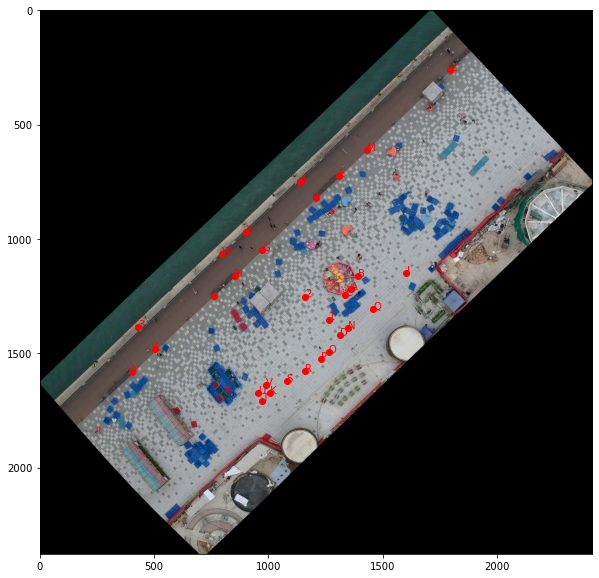

In [10]:
# Plot all reference points
f, ax = plt.subplots(figsize = (10,10))
ax.imshow(targetimg)
ax.scatter(hmatrix['x_ta'], hmatrix['y_ta'], color = 'red')
n = hmatrix.origin_id.values
for i, txt in enumerate(n):
    ax.annotate(txt, (hmatrix['x_ta'][i], hmatrix['y_ta'][i]), size = 10, color = 'red')

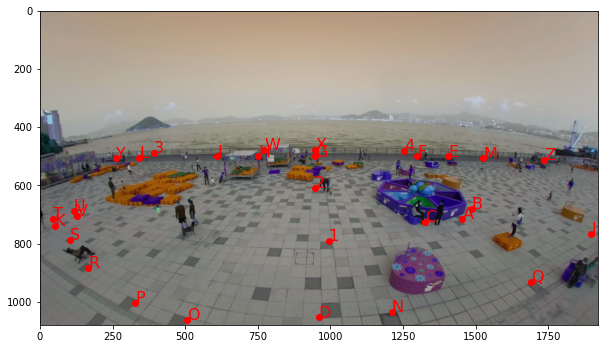

In [31]:
fig = plt.subplots(figsize = (10,10))

plt.imshow(originimg)
plt.scatter(hmatrix['x_or'], hmatrix['y_or'], color = 'red')
n = hmatrix.origin_id.values
for i, txt in enumerate(n):
    plt.annotate(txt, (hmatrix['x_or'][i], hmatrix['y_or'][i]), size = 16, color = 'red')
plt.show()

# Identify the Homography

In [12]:
'''

pts_src and pts_dst are numpy arrays of points

in source and destination images. We need at least

corresponding points.

'''
pts_src = np.array([(x,y) for x,y in zip(hmatrix['x_or'], hmatrix['y_or'])])

pts_dst  = np.array([(x,y) for x,y in zip(hmatrix['x_ta'], hmatrix['y_ta'])])

h, status = cv2.findHomography(pts_src, pts_dst)

'''
The calculated homography can be used to warp

the source image to destination. Size is the

size (width,height) of im_dst
'''
width,height = targetimg.shape[:2]
size = (height, width)
im_dst = cv2.warpPerspective(originimg, h, size)

In [13]:
h

array([[-2.83969313e-01, -4.37492658e+00,  2.02597443e+03],
       [ 4.52851848e-01, -4.82322634e+00,  1.51001654e+03],
       [ 8.12491234e-05, -3.05373285e-03,  1.00000000e+00]])

## Transform the image and test

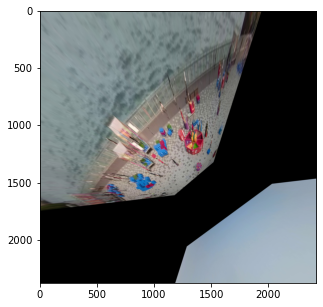

In [14]:
fig = plt.subplots(figsize = (5,5))
plt.imshow(im_dst)

In [15]:
# load some prediction results from a yolo tracking model
trace = pd.read_csv(os.path.join(folder, 'trace_a_1000_1500.csv'))
trace.head()

,frame_id,track_id,bbox0,bbox1,bbox2,bbox3,6,7,8,9,loc_x,loc_y
0,1000,30,1311.45,465.96,28.44,46.43,1,-1,-1,-1,1325.670,512.39
1,1000,263,27.24,609.43,37.31,64.60,1,-1,-1,-1,45.895,674.03
2,1000,308,1214.55,497.04,39.01,62.80,1,-1,-1,-1,1234.055,559.84
3,1000,421,996.15,459.11,23.90,44.35,1,-1,-1,-1,1008.100,503.46
4,1000,587,842.16,854.95,53.79,104.90,1,-1,-1,-1,869.055,959.85


In [16]:
def projectPlan(df, h, x, y):
    pts = df[[x, y]].values
    ## (n, 1, 2)
    pts1 = pts.reshape(-1,1,2).astype(np.float32)
    dst1 = cv2.perspectiveTransform(pts1, h)
    return dst1


def pixel2coord(col, row, ds):
    # 3. transform to 2326 geolocation
    c, a, b, f, d, e = ds.GetGeoTransform()
    """Returns global coordinates to pixel center using base-0 raster index"""
    xp = a * col + b * row + a * 0.5 + b * 0.5 + c
    yp = d * col + e * row + d * 0.5 + e * 0.5 + f
    return(xp, yp)

In [17]:
# find person's foot location
trace['loc_x'] = (trace['bbox0'] + trace['bbox0'] + trace['bbox2'])/2
trace['loc_y'] = (trace['bbox1'] + trace['bbox3'])

# use the homography to project to plan
trs2 = projectPlan(
    trace, 
    h, 
    'loc_x', 
    'loc_y')
trace['x'] = trs2[:,:,0]
trace['y'] = trs2[:,:,1]

In [18]:
trace['coords'] = trace.apply(lambda x: pixel2coord(x['x'], x['y'], dsA),axis = 1)
trace['x_2326'] = trace['coords'].apply(lambda x: x[0])
trace['y_2326'] = trace['coords'].apply(lambda x: x[1])

In [20]:
trace.head()

,frame_id,track_id,bbox0,bbox1,bbox2,bbox3,6,7,8,9,loc_x,loc_y,x,y,coords,x_2326,y_2326
0,1000,30,1311.45,465.96,28.44,46.43,1,-1,-1,-1,1325.670,512.39,1295.740356,790.000244,"(831347.2493517137, 816269.7549833808)",831347.249352,816269.754983
1,1000,263,27.24,609.43,37.31,64.60,1,-1,-1,-1,45.895,674.03,887.454102,1631.171997,"(831329.0911160202, 816232.3444886982)",831329.091116,816232.344489
2,1000,308,1214.55,497.04,39.01,62.80,1,-1,-1,-1,1234.055,559.84,1269.772949,1036.168091,"(831346.0944700709, 816258.8068495578)",831346.094470,816258.806850
3,1000,421,996.15,459.11,23.90,44.35,1,-1,-1,-1,1008.100,503.46,1016.180115,1013.698364,"(831334.8161122926, 816259.8061741109)",831334.816112,816259.806174
4,1000,587,842.16,854.95,53.79,104.90,1,-1,-1,-1,869.055,959.85,1300.759766,1465.187500,"(831347.4725863042, 816239.7265270553)",831347.472586,816239.726527


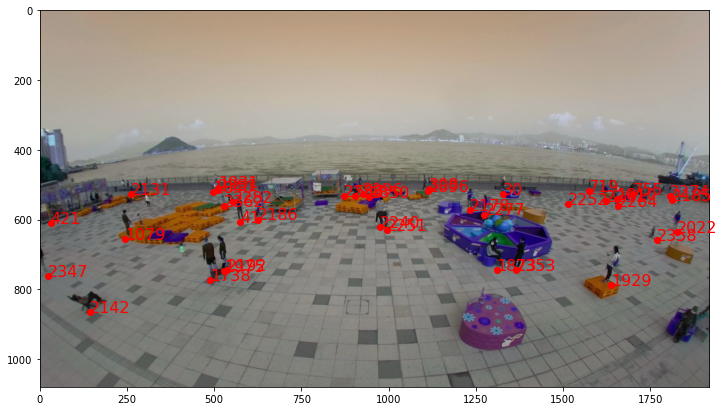

In [32]:
sample = trace[(trace['frame_id'] == 1222)].reset_index(drop = True)
# Show people's location at images
fig = plt.subplots(figsize = (12,12))

# plt.imshow(originimg)
plt.imshow(originimg)
plt.scatter(sample['loc_x'], sample['loc_y'], color = 'red')
# plt.plot(*zip(*(bound+bound[:1])), marker='o', color = 'cyan')
n = sample.track_id.values
for i, txt in enumerate(n):
    plt.annotate(txt, (sample['loc_x'][i], sample['loc_y'][i]), size = 16, color = 'red')
plt.show()

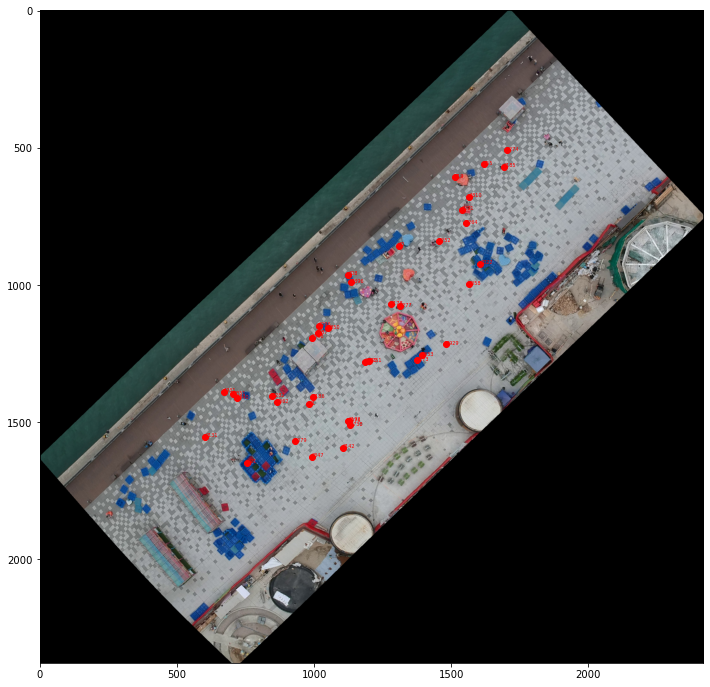

In [34]:
import seaborn as sns
# remove outliers
trace = trace[(trace['x'] > 0) & (trace['y'] > 0)].reset_index(drop = True)
# plot to image and see the location of people on the ground
fig = plt.subplots(figsize = (12,12))

# plt.imshow(originimg)
plt.imshow(targetimg)
plt.scatter(sample['x'], sample['y'], color = 'red')
# plt.plot(*zip(*(bound+bound[:1])), marker='o', color = 'cyan')
n = sample.track_id.values
for i, txt in enumerate(n):
    plt.annotate(txt, (sample['x'][i], sample['y'][i]), size = 5, color = 'red')
plt.show()

### plot the individual traces on the image

In [40]:
trace.groupby('track_id').size()

track_id
30      500
41      384
83       19
263      15
308     389
       ... 
2880     20
2909      4
2919      5
2924      4
2933      1
Length: 215, dtype: int64

In [45]:
sel_track = trace[(trace['track_id'] == 30)].reset_index(drop = True)

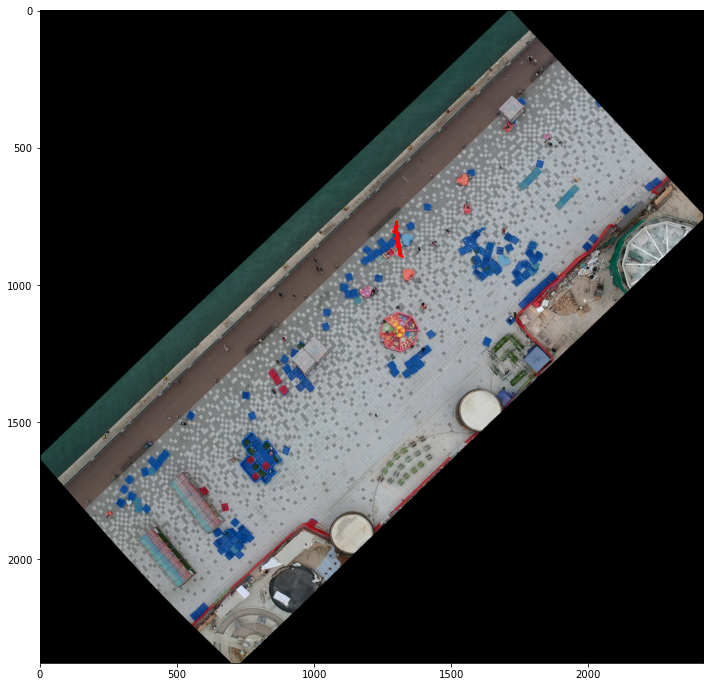

In [47]:
fig = plt.subplots(figsize = (12,12))

# plt.imshow(originimg)
plt.imshow(targetimg)
plt.scatter(sel_track['x'], sel_track['y'], color = 'red', s= 3)

### Plot a heatmap of people concentration using h3 index